## This Image Segementation is mainly divided into two parts.

### This is the first part where the model is trained on entire dataset. Since the dataset, in its raw form, is not well-organized there is quite extensive preprocessing done on both the data images and labels.

### Therefore, it advisable that for a beginner that the pipeline built in next section should be followed since it is well orginized and smaller than this.


The data visualization shall be done here to show the characteristics of the dataset. However if you want to know more about the dataset, you may see here- <a href="https://groups.csail.mit.edu/vision/datasets/ADE20K/">ADE20K Dataset</a>


We first start by downloading the dataset.

In [0]:
!curl https://groups.csail.mit.edu/vision/datasets/ADE20K/ADE20K_2016_07_26.zip -o ADE20K_2016_07_26.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3864M  100 3864M    0     0  10.6M      0  0:06:03  0:06:03 --:--:-- 9048k


Since the dataset is by default in the zip format, we first shall have to unzip it. Next if you would like to know about the disk usage of each component of the dataset, you may un-comment the commented line.

In [ ]:
!unzip ADE20K_2016_07_26.zip
# !du -h ADE20K_2016_07_26

I have used some of the magic functions available in jupyter notebook to make working easier. The `autoreload` function make sure that updated modules are reloaded before executing the code. The`matplotlib inline` function makes sure that the output of all the graphs and figures is done here in the jupyter notebook itself. 

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

The below mentioned library is the one that is used to build the U-Net model and train on the downloaded dataset.

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

The first step is to read the entire dataset and store it in some variable so as to start with the pre-processing.

In [0]:
import glob

path = '/content/ADE20K_2016_07_26/images'

files = [f for f in glob.glob(path + "****/***/**/*.txt", recursive=True)]

In [0]:
f = open(files[0])

<_io.TextIOWrapper name='/content/ADE20K_2016_07_26/images/training/r/reading_room/ADE_train_00015694_atr.txt' mode='r' encoding='UTF-8'>

### Labels Pre-processing

On investigating the structure of labels in the dataset, it is found that they are in a really difficult-to-understand form. Therefore, we need to preprocess all the labels to turn it into a form that can be fed to a model.

In [0]:
lineList = [line.rstrip('') for line in open(files[0])]

In [ ]:
linelist[:20]

In [0]:
list_new = []
for file in files:
  
  try:
    with open(file) as f:
      lineList = [line.rstrip('') for line in f]
      for word in lineList:
        word_list = word.split(' ')
        for only_word in word_list:
          if only_word not in list_new:
            list_new.append(only_word)
            
  except IOError as exc:
    if exc.errno != errno.EISDIR:
            raise

In [ ]:
list_new[:50]

In [ ]:
import re 
  
def remove(list): 
    pattern = '[,]'
    list = [re.sub(pattern, '', i) for i in list] 
    pattern = '[0-9]'
    list = [re.sub(pattern, '', i) for i in list] 
    pattern = '[#]'
    list = [re.sub(pattern, '', i) for i in list] 
    pattern = '["\n"]'
    list = [re.sub(pattern, '', i) for i in list] 
    return list
  
# Driver code  
  
list_new4 = remove(list_new)
# print(list_new1) 

In [ ]:
list_new5 = []

for i in list_new4:
  if i not in list_new5:
    list_new5.append(i)
    
    
# print(list_new5)

In [0]:
list_new5.remove('')

As it can be seen in the below cell, all of the labels are now into proper condition.

In [0]:
 codes = array(list_new5); codes

array(['wall', 'floor', 'flooring', 'carpet', ..., 'gap', 'sawmill', 'portfolio', 'musicians'], dtype='<U36')

It is obvious in the Image segmentation task that we have a target as a segmented image for every normal image. Hence, we code a function `get_y_fn` that returns a target segmented image, for every input image.

In [0]:
def get_y_fn(x): return Path(str(Path(x.parent)) + '/' + x.name[:-4] + '_seg.png')

In [0]:
fnames = get_image_files(path/'val')

In [0]:
Path(files[0])

PosixPath('/content/ADE20K_2016_07_26/images/training/r/reading_room/ADE_train_00015694_atr.txt')

Below is an example of the how the `get_y_fn` works.

In [0]:
get_y_fn(Path('/ADE20K_2016_07_26/images/training/r/reading_room/ADE_train_00015694.jpg'))

PosixPath('/ADE20K_2016_07_26/images/training/r/reading_room/ADE_train_00015694_seg.png')

In [0]:
bs = 1 #batchsize

The below cell creates a dataset and stores it in the variable src

In [0]:
src = (SegmentationItemList.from_folder(path = 'ADE20K_2016_07_26/images', extensions = ['.jpg'], recurse=True)
       .split_by_folder(train='training', valid='validation')       
       .label_from_func(get_y_fn, classes = codes, ignore_empty=True))

Once the dataset is created, it cannot be directly sent for training, because what if we needed to augment the data or maybe randomly split it into test train data or cluster the data into batch to increase utilization of GPU. This is why we use dataloader. The below cell performs the similar functionality

In [0]:
data = (src.transform(get_transforms(), size = 250, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

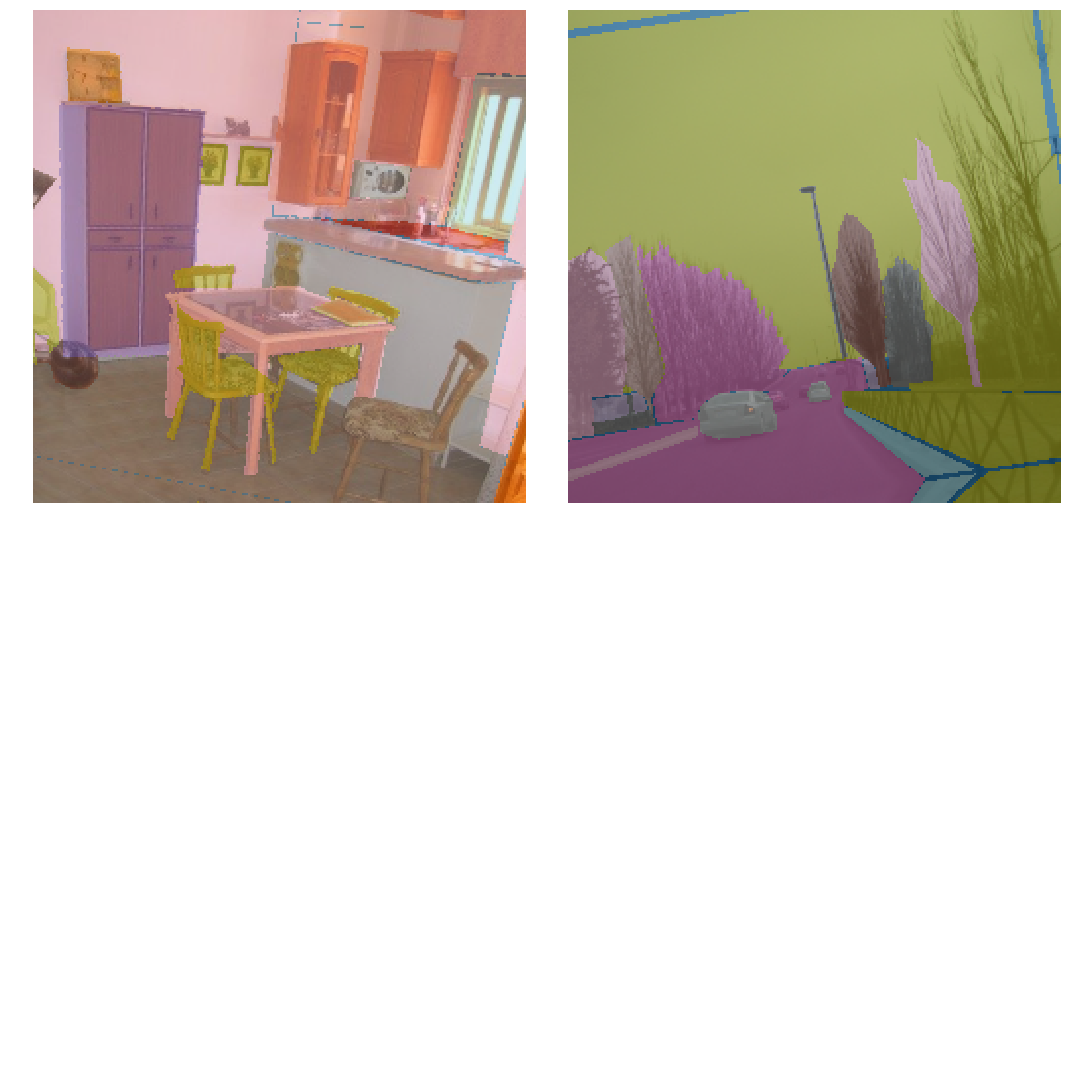

In [0]:
data.show_batch(2, figsize=(15, 15))

It is obvious that the definition of accuracy shall not be the same as in classification task. Therefore, we provide the definition of accuracy for segmentation tasks. 

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
# void_code = name2id['Null']

def seg_acc(input, target):
    target = target.squeeze(1)
    mask = True
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=seg_acc

wd=1e-2

The below cell is the one that aggregates everything into a complete pipeline. U-Net architecture is used for the segmentaion. You can learn more about U-Net <a href="https://en.wikipedia.org/wiki/U-Net">here</a> or in its <a href="https://arxiv.org/abs/1505.04597">paper</a>

In [0]:
learn = unet_learner(data, models.vgg16_bn, metrics=metrics, wd=wd ).to_fp16()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:08<00:00, 63677510.00it/s]


It can be seen that I have wrapped the training method into a method called `to_fp16`. This is because the U-Net architectures usually are computationally expensive and can easily exhibit the resources available. Therefore, I have limited the values of the parameters to a 16 bit precision.

In [0]:
to_fp16(learn.fit_one_cycle(1))
# learn.recorder.plot()

Usually, when we use a transfer learning model, we also inherit its pretrained weights. This is a method to unfreeze those pretrained weights and train the model from scratch.

In [0]:
learn.unfreeze()

In [0]:
lr_find(learn, num_it=1000)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


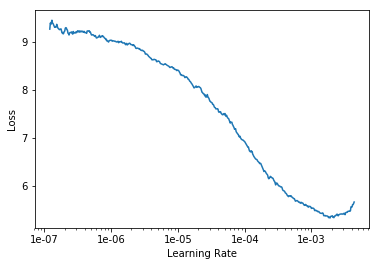

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, slice(0.002, 0.0002))

epoch,train_loss,valid_loss,acc_camvid,time


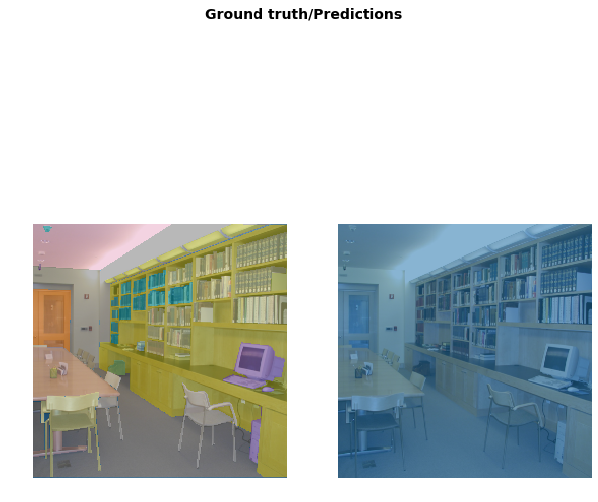

In [0]:
learn.show_results(rows=3, figsize=(10,10))

In [0]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


# The Same dataset in different form. (Might be easier to get into right form for both data and classes. It is also smaller in size.)

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

In [1]:
!curl http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip -o ADEChallengeData2016.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  922M  100  922M    0     0  23.6M      0  0:00:38  0:00:38 --:--:-- 26.7M


In [ ]:
!unzip  ADEChallengeData2016.zip

In [3]:
!du -h ADEChallengeData2016

121M	ADEChallengeData2016/annotations/training
13M	ADEChallengeData2016/annotations/validation
134M	ADEChallengeData2016/annotations
798M	ADEChallengeData2016/images/training
81M	ADEChallengeData2016/images/validation
878M	ADEChallengeData2016/images
1012M	ADEChallengeData2016


In [0]:
import re 


listList= []
with open('./ADEChallengeData2016/objectInfo150.txt') as f:
  lineList = [line.rstrip('') for line in f]
  

def remove(list): 
    pattern = '[0-9\t\n\.]'
    list = [re.sub(pattern, '', i) for i in list] 
    return list
  
# Driver code  
  
list_new1 = remove(lineList)
list_new2 = []
flist = [wordlist.split(',') for wordlist in list_new1]

for alist in flist:
  for word in alist:
    if word not in list_new2:
      list_new2.append(word)
      
list_new2.remove('IdxRatioTrainValName')
codes = array(list_new2)

In [48]:
len(codes); codes

array(['wall', 'building', ' edifice', 'sky', ..., 'glass', ' drinking glass', 'clock', 'flag'], dtype='<U30')

In [54]:
fname = get_image_files('./ADEChallengeData2016/images/training')
fname[:5]

[PosixPath('ADEChallengeData2016/images/training/ADE_train_00001444.jpg'),
 PosixPath('ADEChallengeData2016/images/training/ADE_train_00009104.jpg'),
 PosixPath('ADEChallengeData2016/images/training/ADE_train_00007724.jpg'),
 PosixPath('ADEChallengeData2016/images/training/ADE_train_00015020.jpg'),
 PosixPath('ADEChallengeData2016/images/training/ADE_train_00011386.jpg')]

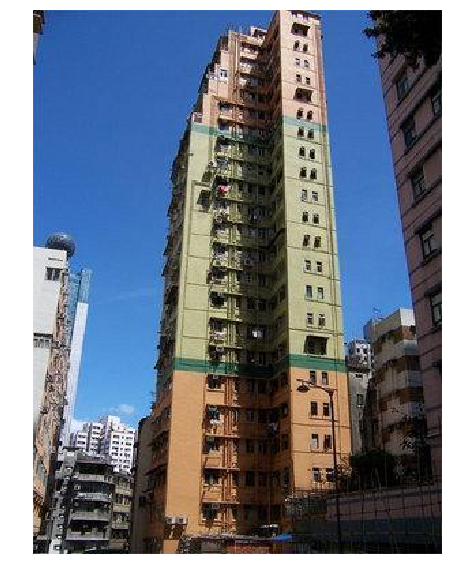

In [65]:
open_image(fname[0]).show(figsize=(20,10),alpha=1)

In [0]:
flabel = get_image_files('./ADEChallengeData2016/annotations/training')

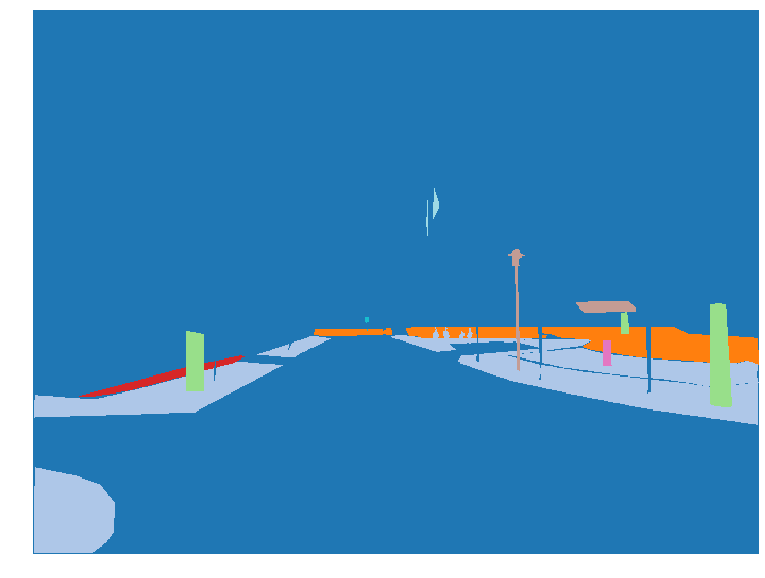

In [67]:
open_mask(flabel[0]).show(figsize=(20,10),alpha=1)

In [0]:
get_y_fn = lambda x: Path(str(x.parent.parent.parent) + '/annotations/' + str(x.parent.name) + '/' + str(x.name)[:-3] + 'png')

In [0]:
open_image(get_y_fn(fname[0]))

In [0]:
bs=4

In [0]:
src = (SegmentationItemList.from_folder('/content/ADEChallengeData2016/images')
       .split_by_folder(train = 'training', valid = 'validation')
       .label_from_func(get_y_fn, classes=codes))
data = (src.transform(get_transforms(), size=300,tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))


In [0]:
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = True
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
# metrics=accuracy
wd=1e-2
learn = unet_learner(data, models.resnet18, metrics=metrics, wd=wd).to_fp16()

In [87]:
lr_find(learn, num_it=2000)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.17E-04
Min loss divided by 10: 7.59E-05


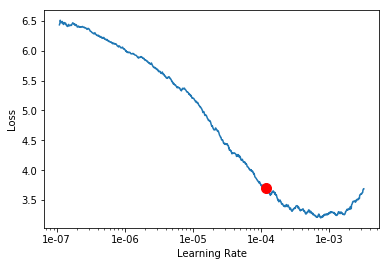

In [89]:
learn.recorder.plot(suggestion=True)

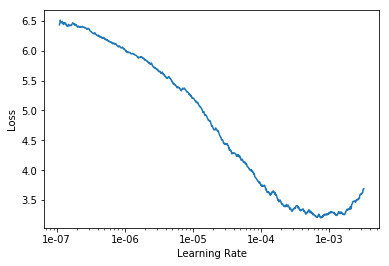

In [90]:
learn.recorder.plot()

In [91]:
learn.fit_one_cycle(3, slice(1e-04))

epoch,train_loss,valid_loss,acc_camvid,time
0,2.163140,1.928020,0.543594,32:53
1,1.788890,1.641974,0.587524,32:53
2,1.658305,1.509049,0.611152,32:53


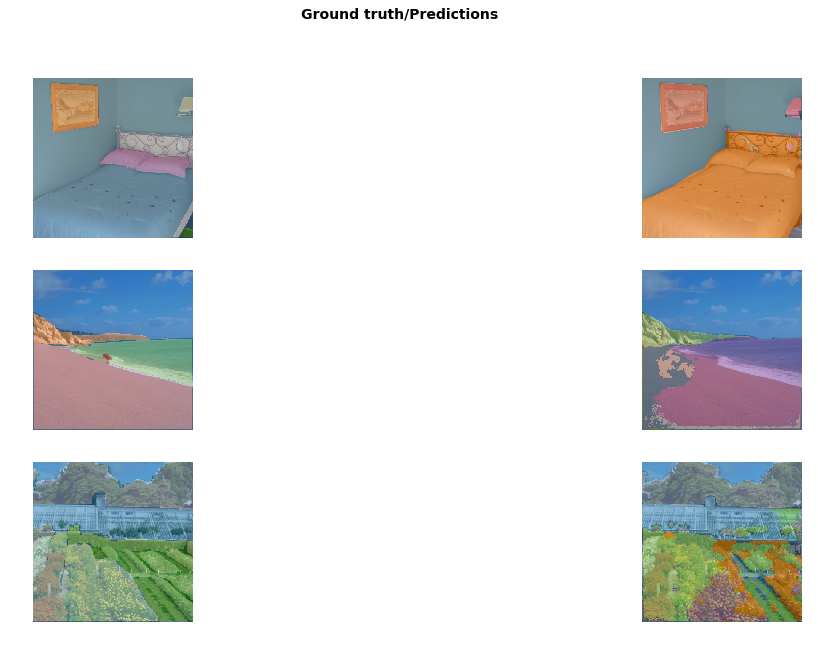

In [101]:
learn.show_results(rows=3, figsize = (20, 10))

## With ResNet34

In [0]:
bs = 8

In [0]:
data = (src.transform(get_transforms(), size=300,tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))


In [0]:
metrics=acc_camvid
# metrics=accuracy
wd=1e-2
learn_res = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()

In [97]:
lr_find(learn_res, num_it=2000)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


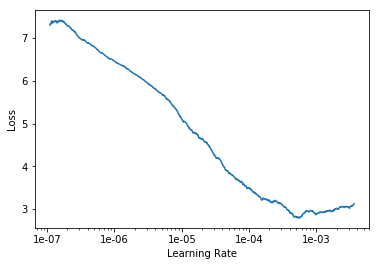

In [98]:
learn_res.recorder.plot()

Min numerical gradient: 4.37E-05
Min loss divided by 10: 5.65E-05


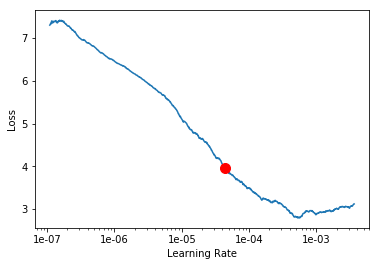

In [102]:
learn_res.recorder.plot(suggestion=True)

In [0]:
learn_res.save('stage-1')

In [0]:
learn_res.load('stage-1');

In [107]:
learn_res.fit_one_cycle(5, slice(4.37e-05))

epoch,train_loss,valid_loss,acc_camvid,time
0,2.294186,2.093654,0.533784,32:42
1,1.844802,1.731548,0.579193,32:47
2,1.635838,1.555428,0.603889,32:46
3,1.538231,1.452198,0.623123,32:45
4,1.476429,1.427548,0.627252,32:44


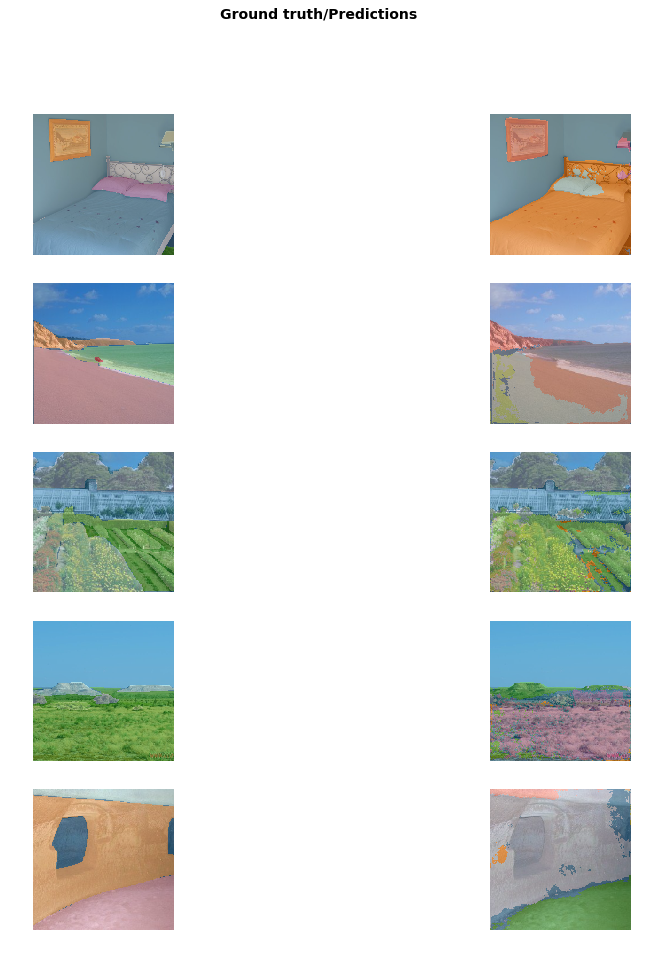

In [109]:
learn_res.show_results(rows=5, figsize=(15,15))

In [0]:
!sync; echo 1 > /proc/sys/vm/drop_caches

/bin/bash: /proc/sys/vm/drop_caches: Read-only file system


In [0]:
!free && sync && echo 3 > /proc/sys/vm/drop_caches && free

              total        used        free      shared  buff/cache   available
Mem:       13335276     3708404     1025380       83308     8601492    10307020
Swap:             0           0           0
/bin/bash: /proc/sys/vm/drop_caches: Read-only file system


In [0]:
!sudo sh -c 'echo 1 >/proc/sys/vm/drop_caches'

sh: 1: cannot create /proc/sys/vm/drop_caches: Read-only file system


In [0]:
!free 

              total        used        free      shared  buff/cache   available
Mem:       13335276     3709280      885336       83308     8740660    10307368
Swap:             0           0           0


In [0]:
!!free -m

['              total        used        free      shared  buff/cache   available',
 'Mem:          13022        3617        1005          81        8399       10069',
 'Swap:             0           0           0']